# Imports

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data preparation

### 1.1. Read data from file

In [6]:
#load the datasets (train data and test data which are pre-splitted)
data1 = MNIST(root='MNIST_dataset', train=True, download=True)
data2 = MNIST(root='MNIST_dataset', train=False, download=True)

#concatenate the data and labels from train and test datasets
all_images = torch.cat((data1.data, data2.data), dim=0)
all_labels = torch.cat((data1.targets, data2.targets), dim=0)

Now, we have 70,000 images intotal.

In [7]:
x = all_images.numpy()
y = all_labels.numpy()

print("Total images:", x.shape[0])

Total images: 70000


### 1.2. Normalizing the data

In [8]:
x = x / 255.0  # Normalize pixel values to [0, 1] range

print("min pixel value:", x.min(), ", max pixel value:", x.max())

min pixel value: 0.0 , max pixel value: 1.0


### 1.3. Splitting into train, validtaion and test sets

In [9]:
x_train, x_rest, y_train, y_rest = train_test_split(x, y, train_size= 0.6, random_state=42, stratify=y) # 60% train, 40% to split again into val and test
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, train_size=0.5, random_state=42, stratify=y_rest) # 40% * 50% = 20% val, 20% test

print("Training set = ", x_train.shape[0])
print("Validation set = ", x_val.shape[0])
print("Test set = ", x_test.shape[0])

Training set =  42000
Validation set =  14000
Test set =  14000


### 1.4. Pytorch DataLoaders

In [10]:
# change from numpy arrays to tensors
x_train_tensor = torch.from_numpy(x_train).unsqueeze(1).float()
y_train_tensor = torch.from_numpy(y_train).long()

x_val_tensor = torch.from_numpy(x_val).unsqueeze(1).float()
y_val_tensor = torch.from_numpy(y_val).long()

x_test_tensor = torch.from_numpy(x_test).unsqueeze(1).float()
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders with batch size = 64 to optimize training
train_NN_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_NN_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_NN_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Neural Network model
### 2.1. Feed Forward NN

In [11]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, number_hidden_layers, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size)) 
        for i in range(number_hidden_layers-1):
            self.layers.append(nn.Linear(hidden_size, hidden_size)) 
        self.layers.append(nn.Linear(hidden_size, output_size)) 

        self.weight_initialization()

    def weight_initialization(self):
        # He initialization
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, nonlinearity= 'relu')
                
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
   
    def forward(self, x):
        
        x = x.view(x.size(0), -1) # flatten input (28x28 to 784)
        
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        x = self.layers[-1](x)

        return x

### 2.2. Training the NN model

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for gpu acceleration
print(f"Using {device}") #check if gpu acceleration is working

INPUT_SIZE = 784
NUMBER_HIDDEN_LAYERS = 2
HIDDEN_SIZE = 64
OUTPUT_SIZE = 10 

LEARNING_RATE = 0.01
NUM_EPOCHS = 100

training_losses = []
training_accurices = []
validation_losses = []
validation_accurices = []

model = FeedForwardNN(INPUT_SIZE, NUMBER_HIDDEN_LAYERS, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

num_total_steps = len(train_NN_loader)
for epoch in range(NUM_EPOCHS):
    
    # training loop
    model.train()
    current_train_loss = 0
    total = 0
    correct = 0

    for i, (image, label) in enumerate(train_NN_loader):
        image = image.to(device)
        label = label.to(device)

        #forward
        outputs = model(image)
        loss = loss_function(outputs, label)
        current_train_loss += loss.item()

        #bacward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    average_train_loss = current_train_loss / len(train_NN_loader)
    train_accuracy = 100 * correct / total

    training_losses.append(average_train_loss)
    training_accurices.append(train_accuracy)

    #validation loop
    model.eval()
    current_val_loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for i, (image, label) in enumerate(val_NN_loader):
            image = image.to(device)
            label = label.to(device)

            #forward
            outputs = model(image)
            loss = loss_function(outputs, label)
            current_val_loss += loss.item()

            #calc accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    #calculate average validation loss and accuracy
    average_val_loss = current_val_loss / len(val_NN_loader)
    validation_accuracy = 100 * correct / total

    validation_losses.append(average_val_loss)
    validation_accurices.append(validation_accuracy)
    print(f"Epoch: {epoch+1} / {NUM_EPOCHS} | avg train loss: {average_train_loss:.4f} | train accuracy : {train_accuracy:.2f}|avg validation loss: {average_val_loss:.4f} | validation accuracy: {validation_accuracy:.2f} ")

Using cpu


Epoch: 1 / 100 | avg train loss: 0.9227 | train accuracy : 74.68|avg validation loss: 0.4688 | validation accuracy: 87.21 
Epoch: 2 / 100 | avg train loss: 0.3934 | train accuracy : 89.07|avg validation loss: 0.3610 | validation accuracy: 89.78 
Epoch: 3 / 100 | avg train loss: 0.3236 | train accuracy : 90.78|avg validation loss: 0.3226 | validation accuracy: 90.85 
Epoch: 4 / 100 | avg train loss: 0.2889 | train accuracy : 91.75|avg validation loss: 0.2951 | validation accuracy: 91.57 
Epoch: 5 / 100 | avg train loss: 0.2649 | train accuracy : 92.44|avg validation loss: 0.2716 | validation accuracy: 92.26 
Epoch: 6 / 100 | avg train loss: 0.2466 | train accuracy : 92.92|avg validation loss: 0.2568 | validation accuracy: 92.71 
Epoch: 7 / 100 | avg train loss: 0.2318 | train accuracy : 93.32|avg validation loss: 0.2507 | validation accuracy: 92.83 
Epoch: 8 / 100 | avg train loss: 0.2187 | train accuracy : 93.76|avg validation loss: 0.2331 | validation accuracy: 93.27 
Epoch: 9 / 100 |

### 2.3 Training VS Validation plots

#### 2.3.1. Loss X epochs gragh

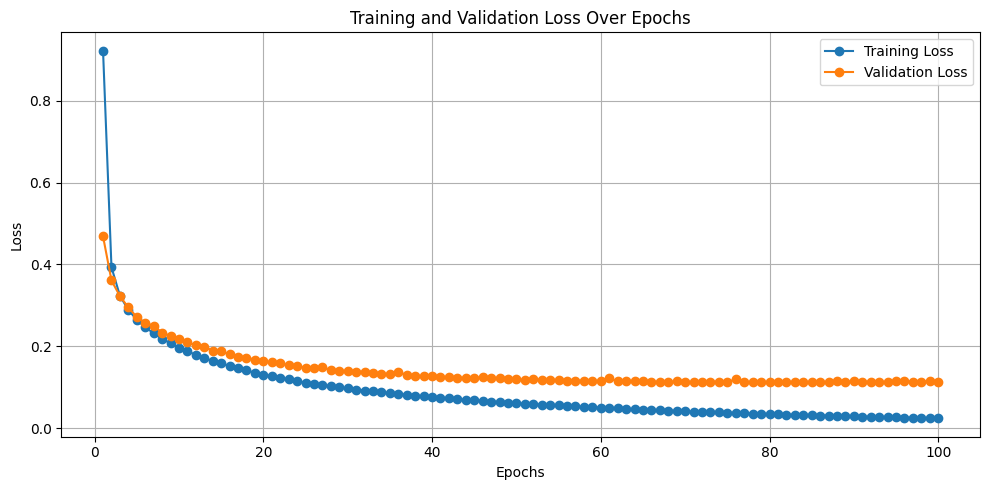

In [13]:
# val - train loss plot
epochs = range(1, len(training_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, 'o-', label='Training Loss')
plt.plot(epochs, validation_losses, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

#### 2.3.2. Accuracy X epochs

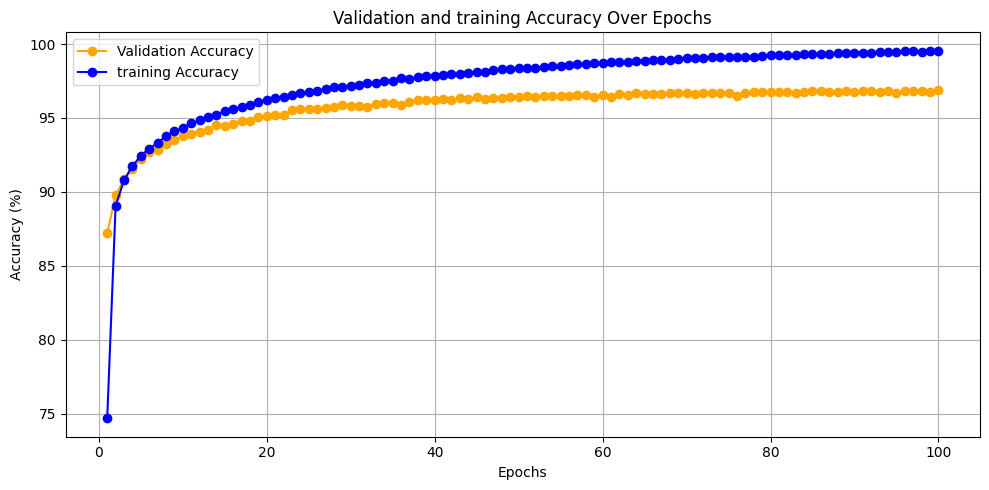

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, validation_accurices, 'o-', label='Validation Accuracy', color='orange')
plt.plot(epochs, training_accurices, 'o-', label='training Accuracy', color='blue')
plt.title('Validation and training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()